- GitHub: https://github.com/mahmood1989?tab=repositories
- Email: mahmoodr@ualberta.ca

# Breast Cancer Gene Expression Profiles
# Model 1 - Gen Expression Data as Input Features
In this notebook, I just used the gene expression data as input features of the model (Columns AF to SZ).

## Import Python libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier


import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image as Image

import seaborn as sn

## General structure of training spreadsheet

The source of this dataset can be downloaded through Kaggle:

https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric

In [2]:
df_raw = pd.read_excel('Model_1.xlsx')
df_raw.head(10)

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,death_from_cancer
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354,Living
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920,Living
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655,Died of Disease
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828,Living
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223,Died of Disease
5,-0.4341,0.6931,0.6909,1.0840,-1.9371,0.9252,1.1520,0.7951,-0.9677,-0.7750,...,0.0395,0.8191,0.1977,-0.2302,-0.5092,-0.3021,0.9357,-0.4217,0.5340,Died of Disease
6,0.2671,0.4129,-1.3333,0.7834,-0.5109,0.8859,-0.2009,1.0128,-0.0697,-0.6300,...,0.0917,1.6814,2.2495,-1.6522,-3.4775,-0.4892,1.1938,-0.1027,0.4331,Living
7,0.3985,1.2710,-1.5306,1.6104,-0.0810,1.3899,-1.1327,0.0384,-0.7457,-2.1944,...,-0.3588,2.4959,0.3744,-0.7101,-2.1453,-1.3027,-0.2308,-0.3450,-0.2023,Died of Other Causes
8,0.8347,-1.5038,0.3436,-0.5550,0.0558,-0.9155,-0.8571,-0.1267,-0.1705,0.6442,...,-0.1405,-0.9780,-0.3030,-0.1640,1.0783,1.8263,-0.5965,0.1502,-0.8837,Died of Other Causes
9,-1.0087,-0.6074,0.0313,1.0975,0.5314,0.9105,-1.5068,-0.0196,0.3726,0.4892,...,-0.4788,3.6125,1.9925,0.2253,-0.8414,1.7093,-0.6921,0.6906,-0.8006,Died of Disease


There are 1904 attributes from 489 input fearures. 1 feature (death_from_cancer) is the output feature.

In [3]:
df_raw.shape

(1904, 490)

There is one null data in the dataset and we delete it.

In [4]:
df_raw.isna().sum()

brca1                0
brca2                0
palb2                0
pten                 0
tp53                 0
                    ..
tulp4                0
ugt2b15              0
ugt2b17              0
ugt2b7               0
death_from_cancer    1
Length: 490, dtype: int64

After deleting the null row, we will have 1903 attributes. 

In [5]:
df_raw.dropna(inplace = True)

In [6]:
df_raw.shape

(1903, 490)

### Convert string variables to categorical classes

In [7]:
df_raw.dtypes

brca1                float64
brca2                float64
palb2                float64
pten                 float64
tp53                 float64
                      ...   
tulp4                float64
ugt2b15              float64
ugt2b17              float64
ugt2b7               float64
death_from_cancer     object
Length: 490, dtype: object

We have 489 input features as float numbers and 1 output feature as string.

In [8]:
(df_raw.dtypes == 'float64').sum()

489

In [9]:
(df_raw.dtypes == 'object').sum()

1

The output (death_from_cancer) is the string type with three categories as:
- Living (Class 0)
- Died of Other Causes (Class 0)
- Died of Disease (Class 1)
If a patient dies because of breast cancer, we categorize it as Class 1, otherwise Class 0 is assigned.

In [10]:
df1 = df_raw.copy(deep = True)

In [11]:
df1['death_from_cancer'].replace('Living', 0, inplace = True)
df1['death_from_cancer'].replace('Died of Other Causes', 0, inplace = True)
df1['death_from_cancer'].replace('Died of Disease', 1, inplace = True)

Among 1903 cases in this dataset, 622 patients died from cancer (33% of total).

In [12]:
(df1.death_from_cancer == 1).sum()

622

### Normalization of input features

In [13]:
df = df1.drop('death_from_cancer', axis = 'columns')

In [14]:
df = df.apply(lambda x: (x - x.min(axis = 0)) / ((x.max(axis = 0)) - (x.min(axis = 0))))

In [15]:
df.head(10)

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,0.149373,0.338838,0.307003,0.803884,0.418195,0.617925,0.546577,0.389558,0.314940,0.230759,...,0.107802,0.245352,0.119900,0.499110,0.153390,0.342147,0.286375,0.047420,0.083211,0.165175
1,0.152088,0.469408,0.352149,0.703436,0.364437,0.415257,0.762149,0.482198,0.467018,0.039651,...,0.194046,0.280027,0.345498,0.601434,0.191096,0.610569,0.356793,0.078038,0.179745,0.036808
2,0.358843,0.297620,0.510689,0.609585,0.442372,0.441792,0.726410,0.429977,0.362737,0.200947,...,0.182851,0.251674,0.392755,0.701842,0.215219,0.014938,0.276177,0.210508,0.135859,0.326822
3,0.445632,0.343592,0.302836,0.715116,0.613203,0.326318,0.744198,0.207530,0.361148,0.257139,...,0.179974,0.194865,0.391473,0.592903,0.177239,0.193603,0.351606,0.070653,0.158886,0.131181
4,0.534050,0.288220,0.406985,0.669388,0.417900,0.508985,0.689516,0.501501,0.491916,0.292395,...,0.177490,0.220783,0.188365,0.761859,0.201183,0.472987,0.490682,0.512098,0.403903,0.547486
5,0.287243,0.533106,0.563970,0.763783,0.080357,0.585543,0.728396,0.482060,0.300416,0.239811,...,0.199845,0.249672,0.391064,0.542223,0.174987,0.427697,0.444355,0.174464,0.114587,0.365683
6,0.387435,0.490140,0.339048,0.731063,0.290991,0.579925,0.508219,0.512184,0.399521,0.255663,...,0.093083,0.253500,0.486362,0.756981,0.084552,0.045779,0.419216,0.195879,0.136204,0.342412
7,0.406210,0.621722,0.317125,0.821082,0.354482,0.651979,0.356573,0.377354,0.324916,0.084638,...,0.155193,0.220460,0.576378,0.560718,0.144467,0.217187,0.309914,0.077673,0.119785,0.195872
8,0.468537,0.196231,0.525379,0.585377,0.374686,0.322387,0.401426,0.354509,0.388397,0.394962,...,0.199764,0.236471,0.192454,0.489816,0.179197,0.631953,0.730326,0.047329,0.153343,0.038722
9,0.205141,0.333686,0.490677,0.765253,0.444927,0.583442,0.295691,0.369328,0.448334,0.378017,...,0.210127,0.211660,0.699781,0.730082,0.203956,0.384954,0.714606,0.039397,0.189964,0.057887


In [16]:
df['death_from_cancer'] = df1['death_from_cancer']

In [17]:
df.head(10)

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,death_from_cancer
0,0.149373,0.338838,0.307003,0.803884,0.418195,0.617925,0.546577,0.389558,0.314940,0.230759,...,0.245352,0.119900,0.499110,0.153390,0.342147,0.286375,0.047420,0.083211,0.165175,0
1,0.152088,0.469408,0.352149,0.703436,0.364437,0.415257,0.762149,0.482198,0.467018,0.039651,...,0.280027,0.345498,0.601434,0.191096,0.610569,0.356793,0.078038,0.179745,0.036808,0
2,0.358843,0.297620,0.510689,0.609585,0.442372,0.441792,0.726410,0.429977,0.362737,0.200947,...,0.251674,0.392755,0.701842,0.215219,0.014938,0.276177,0.210508,0.135859,0.326822,1
3,0.445632,0.343592,0.302836,0.715116,0.613203,0.326318,0.744198,0.207530,0.361148,0.257139,...,0.194865,0.391473,0.592903,0.177239,0.193603,0.351606,0.070653,0.158886,0.131181,0
4,0.534050,0.288220,0.406985,0.669388,0.417900,0.508985,0.689516,0.501501,0.491916,0.292395,...,0.220783,0.188365,0.761859,0.201183,0.472987,0.490682,0.512098,0.403903,0.547486,1
5,0.287243,0.533106,0.563970,0.763783,0.080357,0.585543,0.728396,0.482060,0.300416,0.239811,...,0.249672,0.391064,0.542223,0.174987,0.427697,0.444355,0.174464,0.114587,0.365683,1
6,0.387435,0.490140,0.339048,0.731063,0.290991,0.579925,0.508219,0.512184,0.399521,0.255663,...,0.253500,0.486362,0.756981,0.084552,0.045779,0.419216,0.195879,0.136204,0.342412,0
7,0.406210,0.621722,0.317125,0.821082,0.354482,0.651979,0.356573,0.377354,0.324916,0.084638,...,0.220460,0.576378,0.560718,0.144467,0.217187,0.309914,0.077673,0.119785,0.195872,0
8,0.468537,0.196231,0.525379,0.585377,0.374686,0.322387,0.401426,0.354509,0.388397,0.394962,...,0.236471,0.192454,0.489816,0.179197,0.631953,0.730326,0.047329,0.153343,0.038722,0
9,0.205141,0.333686,0.490677,0.765253,0.444927,0.583442,0.295691,0.369328,0.448334,0.378017,...,0.211660,0.699781,0.730082,0.203956,0.384954,0.714606,0.039397,0.189964,0.057887,1


## Feature Selection 
### 1. Univariate Selection
We will have 489 input features that may result in overfitting of the ML model. We should filter the input features that have stronger correlation with the output feature. One technique is "Univariate Selection".

In [18]:
# The input data of this function is df2_regression or df2_classification

def Univariate_Selection (df2, n_features):
    X = df2.drop('death_from_cancer', axis = 'columns')
    y = df2['death_from_cancer']
    
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X,y)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    feature_Scores = pd.concat([dfcolumns,dfscores], axis=1)
    feature_Scores.columns = ['Specs','Score']
    
    Top_features = feature_Scores.nlargest(n_features,'Score')
    
    X_featured_US = pd.DataFrame()  
    for ii in Top_features['Specs']:
        X_featured_US[ii] = X[ii]

    X = X_featured_US.copy()
    X = np.array(X)    
    y = np.array(y)
             
    
    print(Top_features)
    
    return(X, y)


### 2. Feature Importance
The second technique for feature selection is "Feature Importance".

In [19]:
def Feature_Importance (df2, n_features):
    X = df2.drop('death_from_cancer', axis = 'columns')
    y = df2['death_from_cancer']
    
    model_FI = ExtraTreesClassifier()
    model_FI.fit(X,y)
    
    feat_importances = pd.DataFrame(model_FI.feature_importances_, X.columns)
    
    output_FI = pd.DataFrame()
    output_FI ['importance'] = model_FI.feature_importances_
    output_FI ['feature'] = X.columns
    
    output_FI = output_FI.nlargest(n_features, columns = ['importance'], keep = 'first')
    
    X_featured_FI = pd.DataFrame()
    for ii in output_FI['feature']:
        X_featured_FI[ii] = X[ii]
    
    X = X_featured_FI.copy()
    X = np.array(X)
    y = np.array(y)
    
    
    print(output_FI)
    
    return(X, y)

## Machine Learning Models
In this section, we test the performance of different classification models such as Random Forest, Gradient Boost, and Neural Network. 

## 1. Random Forest
We use Univariate_Selection and come up with n_feature = 100 as the optimum number of features.

In [20]:
X, y = Univariate_Selection (df, n_features = 100)

      Specs     Score
120   aurka  5.173416
302    mapt  4.889528
133  bmpr1b  3.466020
26    ccne1  3.240146
39     e2f2  3.122469
..      ...       ...
376   nr2f1  0.404774
189  map3k1  0.404719
89   notch1  0.393046
251   rptor  0.384978
14     msh6  0.384652

[100 rows x 2 columns]


There are several important hyperprameters that should be optimized in the Random Forest model. We use GridSearchCV to find the optimum values of these hyperparameters that result in the maximum accuracy. The algorithm came up with the following values:

ccp_alpha = 0.0005, max_depth = 40, max_features = 'sqrt', max_leaf_nodes = 30, n_estimators = 125

In [21]:
param_grid = [
    {'ccp_alpha' : [0.0005, 0.001, 0.005, 0.01, 0.015, 0.02],
     'max_depth' : [20, 30, 40, 50],
     'max_leaf_nodes' : [30, 40, 50],
     'max_features' : [1, 'sqrt', 'log2'],
     'n_estimators' : [50, 75, 100, 125]   
    }
]

optimal_params = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_)

{'ccp_alpha': 0.0005, 'max_depth': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'n_estimators': 125}


Then we use k-fold cross validation with cv = 10 to test the Random Forest accuracy on different samples of the test dataset.

In [22]:
Random_forest_models = cross_val_score(RandomForestClassifier(ccp_alpha= 0.005, max_depth= 40, max_features= 'sqrt', \
                                                              max_leaf_nodes= 30, n_estimators= 125), X, y, cv = 10)
Random_forest_models

array([0.67539267, 0.67015707, 0.68062827, 0.67894737, 0.66315789,
       0.67894737, 0.65789474, 0.70526316, 0.65789474, 0.67368421])

The average of accuracy over 10 cross validation sets is 0.67.

In [23]:
np.mean(Random_forest_models)

0.6741967484155416

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
Random_forest = RandomForestClassifier(ccp_alpha= 0.005, max_depth= 40, max_features= 'sqrt', \
                                                              max_leaf_nodes= 30, n_estimators= 125)

In [26]:
Random_forest.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.005, max_depth=40, max_features='sqrt',
                       max_leaf_nodes=30, n_estimators=125)

Model accuracy is on test data in around 0.67.

In [27]:
Random_forest.score(X_test, y_test)

0.6666666666666666

In [28]:
y_predicted = Random_forest.predict(X_test)

As shown in the confusion matrix below, the Random Forest model does not have a good accuracy for prediction of class = 1.

Text(69.0, 0.5, 'Truth')

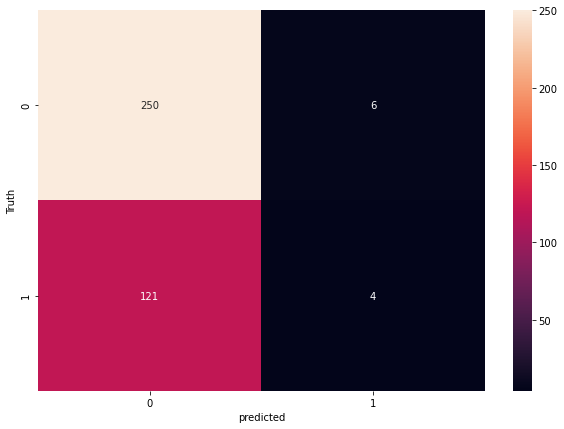

In [29]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.80 which is relatively good. However, F-score of Class = 1 is 0.06 which is very low. The weighted average F-score is 0.56.

In [31]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.67      0.98      0.80       256
           1       0.40      0.03      0.06       125

    accuracy                           0.67       381
   macro avg       0.54      0.50      0.43       381
weighted avg       0.58      0.67      0.56       381



## 2. Gradient Boost

Similar to the Random Forest model, we use Univariate_Selection and n_feature = 100 as the optimum number of features.

In [32]:
X, y = Univariate_Selection (df, n_features = 100)

      Specs     Score
120   aurka  5.173416
302    mapt  4.889528
133  bmpr1b  3.466020
26    ccne1  3.240146
39     e2f2  3.122469
..      ...       ...
376   nr2f1  0.404774
189  map3k1  0.404719
89   notch1  0.393046
251   rptor  0.384978
14     msh6  0.384652

[100 rows x 2 columns]


We use GridSearchCV to find the optimum values of the hyperparameters, in particular learning rate.

In [33]:
param_grid = [
    {'learning_rate' : [0.001, 0.01, 0.1, 0.15],
     'n_estimators' : [50, 80, 100, 150]
    }
]

optimal_params = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_, optimal_params.best_score_)

{'learning_rate': 0.1, 'n_estimators': 50} 0.6773532255836442


In [34]:
Boost_models = cross_val_score(GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 50),X, y,cv = 10)
Boost_models

array([0.69109948, 0.65968586, 0.65968586, 0.72631579, 0.62631579,
       0.65263158, 0.65789474, 0.65263158, 0.68421053, 0.67894737])

The average of accuracy over 10 cross validation sets is 0.67.

In [35]:
np.mean(Boost_models)

0.6689418572609535

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [37]:
gBoostClassifier = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 50)
gBoostClassifier.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

The accuracy of Gradient Boost on test data is 0.69.

In [38]:
gBoostClassifier.score(X_test, y_test)

0.6981627296587927

In [39]:
y_predicted = gBoostClassifier.predict(X_test)

Gradient boost works better in prediction of Class = 1, compared to Random Forest.

Text(69.0, 0.5, 'Truth')

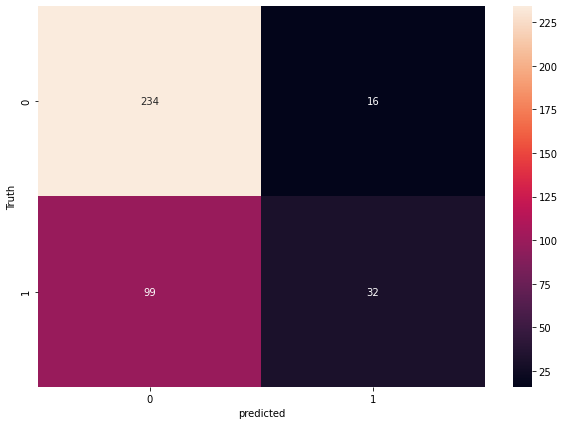

In [40]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.80 which is relatively good. F-score of Class = 1 is 0.36 which is higher than F-score of the Random Forest model (0.06). The weighted average F-score is 0.65 which is fairly better than Random Forest (0.56).

In [41]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       250
           1       0.67      0.24      0.36       131

    accuracy                           0.70       381
   macro avg       0.68      0.59      0.58       381
weighted avg       0.69      0.70      0.65       381



## 3. Neural Network - Classification Model

In this part, we use a shallow neural network for binary classification.

In [57]:
X, y = Univariate_Selection (df, n_features = 100)

      Specs     Score
120   aurka  5.173416
302    mapt  4.889528
133  bmpr1b  3.466020
26    ccne1  3.240146
39     e2f2  3.122469
..      ...       ...
376   nr2f1  0.404774
189  map3k1  0.404719
89   notch1  0.393046
251   rptor  0.384978
14     msh6  0.384652

[100 rows x 2 columns]


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [59]:
X_train.shape

(1522, 100)

In [65]:
NN = keras.Sequential([
    
    keras.layers.Dense(64, input_shape = (100, ), activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation = 'sigmoid'), 
])

NN.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  
history_class = NN.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
48/48 [==============================] - 1s 10ms/step - loss: 0.6663 - accuracy: 0.6078 - val_loss: 0.6236 - val_accuracy: 0.6824
Epoch 2/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.6590 - val_loss: 0.6189 - val_accuracy: 0.6824
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6405 - accuracy: 0.6649 - val_loss: 0.6099 - val_accuracy: 0.6824
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6369 - accuracy: 0.6636 - val_loss: 0.6115 - val_accuracy: 0.6824
Epoch 5/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6252 - accuracy: 0.6629 - val_loss: 0.6038 - val_accuracy: 0.6824
Epoch 6/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.6643 - val_loss: 0.6062 - val_accuracy: 0.6824
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 0.6208 - accuracy: 0.6715 - val_loss: 0.5991 - val_accuracy: 0.6824
Epoch 8/100


Epoch 59/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5788 - accuracy: 0.6846 - val_loss: 0.5761 - val_accuracy: 0.6850
Epoch 60/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5698 - accuracy: 0.6866 - val_loss: 0.5926 - val_accuracy: 0.6929
Epoch 61/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5709 - accuracy: 0.6754 - val_loss: 0.5754 - val_accuracy: 0.6877
Epoch 62/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5746 - accuracy: 0.6715 - val_loss: 0.5744 - val_accuracy: 0.6929
Epoch 63/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5770 - accuracy: 0.6794 - val_loss: 0.5767 - val_accuracy: 0.6850
Epoch 64/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5734 - accuracy: 0.6912 - val_loss: 0.5759 - val_accuracy: 0.6798
Epoch 65/100
48/48 [==============================] - 0s 4ms/step - loss: 0.5720 - accuracy: 0.6873 - val_loss: 0.5751 - val_accuracy: 0.6903
Epoch 

This NN model has 7521 parameters that should be optimized by backpropagation.

In [124]:
NN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                6464      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


The following figures show the profiles of "loss" and "accuracy" with respect to epochs for the training and validation (test) datasets.

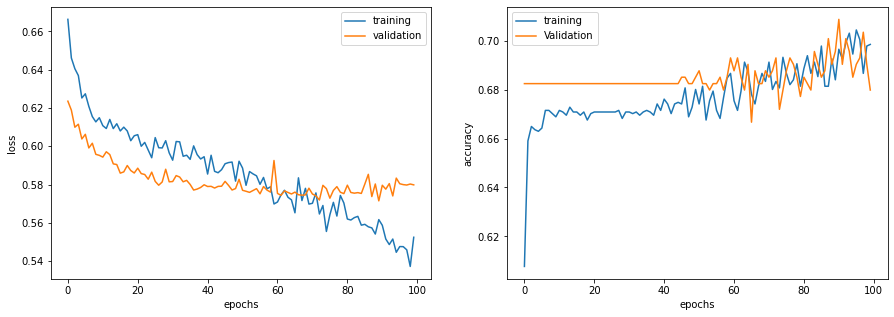

In [66]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(history_class.history['loss'], label = 'training')
plt.plot(history_class.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_class.history['accuracy'], label = 'training')
plt.plot(history_class.history['val_accuracy'], label = 'Validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


The accuracy of the NN model on test set is around 0.68.

In [67]:
NN.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 0.5798 - accuracy: 0.6798


[0.5798258781433105, 0.6797900199890137]

In [68]:
y_predicted = NN.predict(X_test)

In [69]:
y_predicted_labels = []

for ii in y_predicted:
    if ii > 0.5:
        y_predicted_labels.append(1)
    elif ii <= 0.5:
        y_predicted_labels.append(0)

This NN model has a better performance in predicting the Class = 1 compared to Random Forest.

Text(69.0, 0.5, 'Truth')

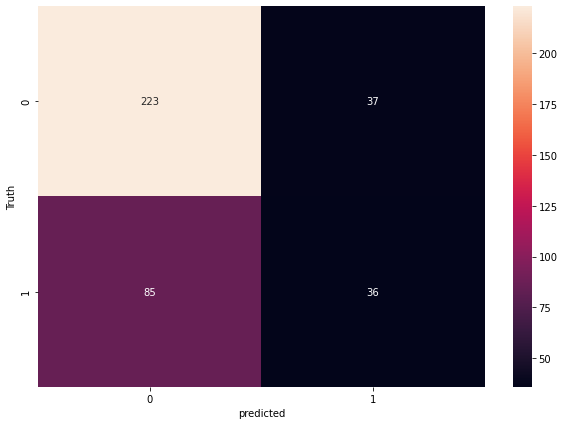

In [70]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.79 which is relatively good and similar to the F-score Gradient Boost. F-score of Class = 1 is 0.37 which is a bit higher than F-score of the Gradient Boost model (0.36). The weighted average F-score is 0.65.

In [71]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79       260
           1       0.49      0.30      0.37       121

    accuracy                           0.68       381
   macro avg       0.61      0.58      0.58       381
weighted avg       0.65      0.68      0.65       381



## Learning curve
### Gradient Boost model
In this subsection, we want to evaluate the learning curve of the Gradient Boost model. The interpretation of this curve will help us to understand why the accuracy of our model is relatively low.

In [73]:
X, y = Univariate_Selection (df, n_features = 100)

      Specs     Score
120   aurka  5.173416
302    mapt  4.889528
133  bmpr1b  3.466020
26    ccne1  3.240146
39     e2f2  3.122469
..      ...       ...
376   nr2f1  0.404774
189  map3k1  0.404719
89   notch1  0.393046
251   rptor  0.384978
14     msh6  0.384652

[100 rows x 2 columns]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.001)

In [75]:
def plot_learning_curve(train_scores, test_scores, train_sizes, fig_name, title, xlabel, ylabel):
    train_mean = 1 - np.mean(train_scores, axis=1)

    test_mean = 1 - np.mean(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean, '--',  label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

    plt.title(title)
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.legend(loc="best")
    plt.savefig(fig_name, bbox_inches='tight')

In [ ]:
train_sizes, train_scores, test_scores = learning_curve \
(GradientBoostingClassifier(), \
 X_train, y_train, cv = 5, train_sizes=np.linspace(0.01, 1.0, 30))

As shown below, there is a big gap between training and validation errors, suggesting a high variance problem. One way to solve this issue is to add more training data to the dataset. It makes sense because we have 100 input features and only 1903 attributes. Adding more data would reduce the gap between training and validation errors.

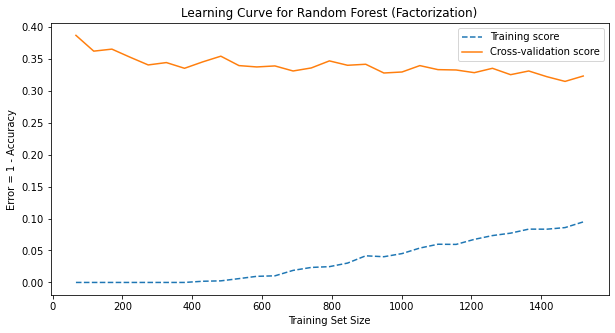

In [78]:
plt.figure(figsize=(10,5))
plot_learning_curve(train_scores,test_scores,train_sizes,"Random_Forest_Curve.png",
           "Learning Curve for Random Forest (Factorization)","Training Set Size","Error = 1 - Accuracy")

### This is the end of Model 1